In [6]:
import pandas as pd
import numpy as np
import gudhi as gd
from gudhi.weighted_rips_complex import WeightedRipsComplex
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
from gudhi.point_cloud.dtm import DistanceToMeasure
from gudhi.hera import wasserstein_distance
from gudhi.representations import PersistenceImage, BettiCurve
from sklearn.decomposition import PCA
import umap
from gudhi.representations.metrics import WassersteinDistance
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import MDS
import os
from scipy import stats
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from scipy import signal
from scipy.stats import levy_stable
from symulacja_py import impsim
#%matplotlib widget

In [2]:
def create_signal(alpha, impulse_amplitude):
    fs = 25000
    fmod = 30
    f_center = 5000
    bandwidth = 1500
    shift = 0

    amp_imp = impulse_amplitude
    alfa = alpha
    skala = 0.5

    varsize = 2*fs
    tt_ts = np.linspace(1/fs,varsize/fs,varsize)
    #szum = np.random.normal(0,skala,varsize) #szum Gaussowski
    szum = levy_stable.rvs(alfa,0,0,skala,varsize)  #szum alfa-stabilny

    signal_l = 9*impsim(fs,varsize,fmod,amp_imp,f_center,bandwidth,shift)+szum
    return signal_l

In [65]:
#generate data under null, i.e. only noise
alpha = 1.8
amplitude = 0
mc_iterations = 1000
print("=============generating data====================")
data = []
for i in range(mc_iterations):
    data.append(create_signal(alpha, amplitude))
#dim * delay should roughly equal len(time_series)/numer_of_periods
dim = 3*833#417# half period
delay = len(data[0])//dim
print("delay", delay)
skip = 1#200#0#100
print(dim*delay)
print(len(data[0])/24)

print("===============computing SWE====================")
tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
point_clouds = tde.transform(data)

for i in range(0,len(point_clouds)):
    point_clouds[i] = point_clouds[i]-np.mean(point_clouds[i],1)[:, None]
    point_clouds[i] = point_clouds[i]/np.sqrt(np.sum(point_clouds[i]**2, 1))[:, None]

print(np.array(point_clouds).shape)
print(len(point_clouds[0]))  
print("=============computing Rips PH==================")
pds = []
weighted = True
for pc in point_clouds:
    if weighted:
        dist = cdist(pc,pc)
        dtm = DistanceToMeasure(5, dim = 10, q=2, metric="precomputed")
        r = dtm.fit_transform(dist)
        ac = WeightedRipsComplex(distance_matrix=dist,weights = 1/r)
    else:
        ac = gd.RipsComplex(points=pc)

    st = ac.create_simplex_tree(max_dimension = 2)
    st.compute_persistence()
    pd = st.persistence_intervals_in_dimension(1)
    pds.append(pd)

print("=============computing betti curves==============")

start = min([np.min(d) for d in pds])-0.005
end = max([np.max(d) for d in pds])+0.005
print(start,end)
start = 2.9
end = 3.7
x = np.linspace(start,end,1000)
bc = BettiCurve(predefined_grid=x)
betti_curves = bc.fit_transform(pds)
avg_bc = np.mean(betti_curves, axis=0)

=============generating data====================
delay 20
49980
2083.3333333333335
===============computing SWE====================
(1000, 40, 2499)
40
=============computing Rips PH==================
=============computing betti curves==============
2.989850841746667 3.093446585348921


In [66]:
acc_thresh = np.quantile(cdist([avg_bc],betti_curves, "chebyshev")[0],0.95)
print(acc_thresh)

24.689999999999998


In [70]:
amplitudes = np.linspace(0,1,11)
test_powers = np.zeros_like(amplitudes)
j=0
for a in amplitudes:
    print("******************",a,"*******************")
    print("=============generating data====================")
    data = []
    for i in range(mc_iterations):
        data.append(create_signal(alpha, a))
    #dim * delay should roughly equal len(time_series)/numer_of_periods
    dim = 3*833#417# half period
    delay = len(data[0])//dim
    print("delay", delay)
    skip = 1#200#0#100
    print(dim*delay)
    print(len(data[0])/24)

    print("===============computing SWE====================")
    tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
    point_clouds = tde.transform(data)

    for i in range(0,len(point_clouds)):
        point_clouds[i] = point_clouds[i]-np.mean(point_clouds[i],1)[:, None]
        point_clouds[i] = point_clouds[i]/np.sqrt(np.sum(point_clouds[i]**2, 1))[:, None]

    print(np.array(point_clouds).shape)
    print(len(point_clouds[0]))  
    print("=============computing Rips PH==================")
    pds = []
    weighted = True
    for pc in point_clouds:
        if weighted:
            dist = cdist(pc,pc)
            dtm = DistanceToMeasure(5, dim = 10, q=2, metric="precomputed")
            r = dtm.fit_transform(dist)
            ac = WeightedRipsComplex(distance_matrix=dist,weights = 1/r)
        else:
            ac = gd.RipsComplex(points=pc)

        st = ac.create_simplex_tree(max_dimension = 2)
        st.compute_persistence()
        pd = st.persistence_intervals_in_dimension(1)
        pds.append(pd)

    print("=============computing betti curves==============")

    start = min([np.min(d) for d in pds])-0.005
    end = max([np.max(d) for d in pds])+0.005
    print(start,end)
    start = 2.9
    end = 3.7
    x = np.linspace(start,end,1000)
    bc = BettiCurve(predefined_grid=x)
    betti_curves = bc.fit_transform(pds)
    dists = cdist([avg_bc],betti_curves, "chebyshev")[0]
    power = np.sum(dists>acc_thresh)/mc_iterations
    test_powers[j] = power
    j=j+1

****************** 0.0 *******************
=============generating data====================
delay 20
49980
2083.3333333333335
===============computing SWE====================
(1000, 40, 2499)
40
=============computing Rips PH==================
=============computing betti curves==============
2.990597598519175 3.0723691010660987
****************** 0.1 *******************
=============generating data====================
delay 20
49980
2083.3333333333335
===============computing SWE====================
(1000, 40, 2499)
40
=============computing Rips PH==================
=============computing betti curves==============
2.989482340738939 3.0702703778654343
****************** 0.2 *******************
=============generating data====================
delay 20
49980
2083.3333333333335
===============computing SWE====================
(1000, 40, 2499)
40
=============computing Rips PH==================
=============computing betti curves==============
2.989792057138599 3.078071609179662
********

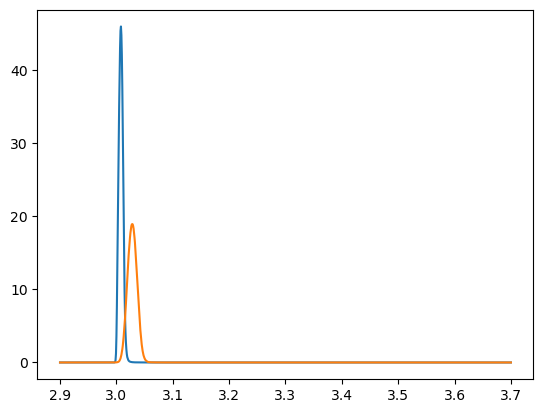

In [71]:
f,ax = plt.subplots()
#ax.scatter(amplitudes, l1_power)
ax.plot(x,avg_bc)
ax.plot(x,np.mean(betti_curves,axis=0))
plt.show()

[0.047 0.05  0.069 0.061 0.118 0.261 0.563 0.934 1.    1.    1.   ]


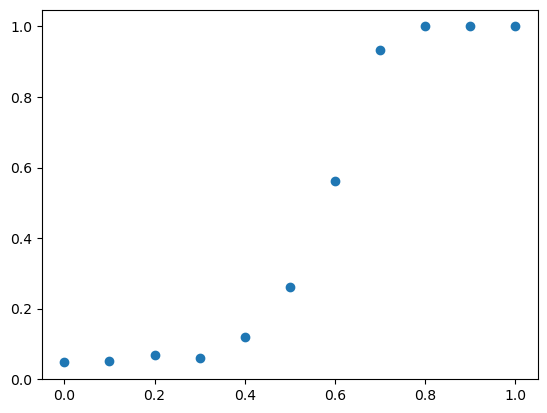

In [74]:
f,ax = plt.subplots()
ax.scatter(amplitudes, test_powers)
print(test_powers)
plt.show()